In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from src.unet import UNet
from src.evaluate import predict

In [2]:
# Load model
checkpoint_path = Path('checkpoints/checkpoint_epoch5.pth')
state_dict = torch.load(str(checkpoint_path), map_location='cpu')
del state_dict['learning_rate']

model = UNet(n_channels=3, n_classes=1)
model.load_state_dict(state_dict)

<All keys matched successfully>

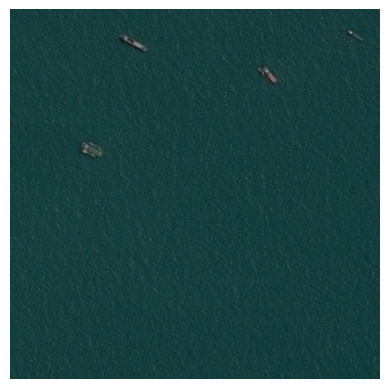

In [3]:
size = 256 # The size of the input images to the network
img_path = Path('data/processed/test/00113a75c.jpg')

img = Image.open(img_path)
if img.width < size:
    ratio = size / img.width
    img = img.resize((size, int(ratio * img.height)))
if img.height < size:
    ratio = size / img.height
    img = img.resize((int(ratio * img.width), size))

w, h = img.width, img.height
img = np.array(img)
plt.imshow(img)
plt.axis('off');

In [4]:
xs = [x for x in range(0, w-size, size)] + [w - size]
ys = [y for y in range(0, h-size, size)] + [h - size]

crops = [torch.from_numpy(img[y:y+size, x:x+size]) for y in ys for x in xs]

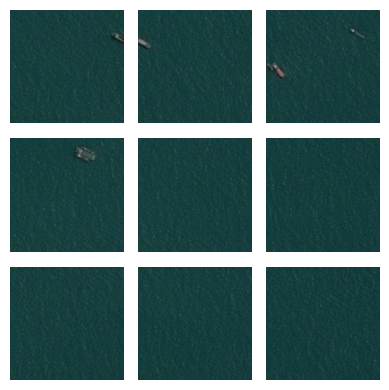

In [5]:
plt.figure(figsize=(4,4))
for i, crop in enumerate(crops):
    plt.subplot(3, 3, i+1)
    plt.imshow(crop)
    plt.axis('off')
plt.tight_layout();

In [6]:
# Prepare input images
inputs = torch.cat([torch.unsqueeze(crop, dim=0) for crop in crops], dim=0)
inputs = inputs.permute((0, 3, 1, 2)).type(torch.float)
inputs /= 255
inputs.shape

torch.Size([9, 3, 256, 256])

In [7]:
# Create prediction
mask_preds = predict(model, inputs)
mask_preds.shape

torch.Size([9, 1, 256, 256])

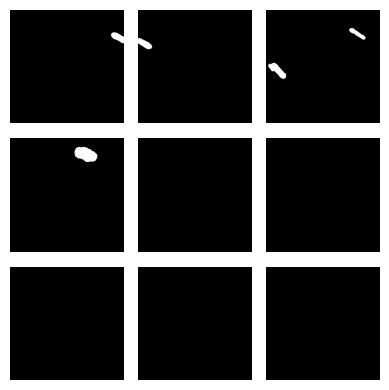

In [8]:
# See predictions
plt.figure(figsize=(4,4))
for i, mask in enumerate(mask_preds):
    plt.subplot(3, 3, i+1)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.axis('off')
plt.tight_layout();

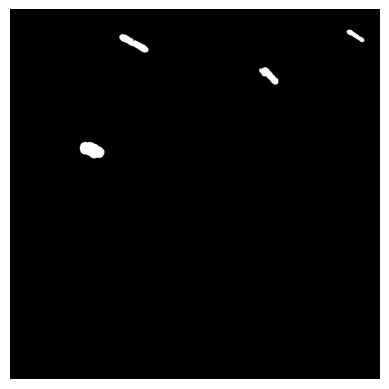

In [9]:
# Create mask for original image
mask = np.empty((h, w), dtype=np.bool_)
for i, crop_mask in enumerate(mask_preds):
    y, x = ys[i//len(xs)], xs[i%len(xs)]
    mask[y:y+size, x:x+size] = crop_mask.numpy()
plt.imshow(mask, cmap='gray')
plt.axis('off');

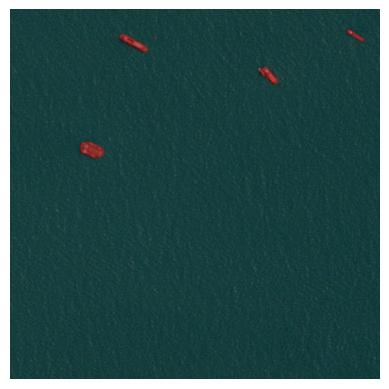

In [10]:
# Create a merged image with alpha values
merged = np.ones((h, w, 4), dtype=np.uint)*255
merged[:,:,:-1] = img
merged[mask, :-1] = merged[mask, :-1]*0.6 + np.array([255, 0, 0])*0.4
plt.imshow(merged)
plt.axis('off');